<a href="https://colab.research.google.com/github/dste/ocr-07/blob/main/07_bad_buzz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade gensim

import spacy.cli
spacy.cli.download("en_core_web_lg")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import spacy
if (False):
    spacy.require_gpu()

from nltk.stem.snowball import SnowballStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import multiprocessing
import gc

root = '/content/drive/My Drive/Ocr/07'

# Analyse exploratoire

In [ ]:
df = pd.read_csv(root+'/Datasets/tweet.csv', encoding='latin1', header=None, usecols=[0, 5])[[5, 0]].rename(columns={5:'tweet', 0:'sentiment'})
df.head()

,tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


le dataset est équilibré, complé et trié

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   tweet      1600000 non-null  object
 1   sentiment  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [ ]:
df = df.groupby('sentiment').sample(frac=0.01, random_state=0)
df.sentiment.value_counts()

0    8000
4    8000
Name: sentiment, dtype: int64

In [ ]:
df.head(80000).sentiment.value_counts()

0    8000
4    8000
Name: sentiment, dtype: int64

In [ ]:
oov = []
stats = []
nlp = spacy.load("en_core_web_lg")
for tweet in nlp.pipe(tqdm(df.tweet.values)):
  stat = {'case':0, 'punct':0, 'space':0, 'stop':0, 'num':0, 'url':0, 'email':0, 'currency':0, '#':0, '@':0, 'oov':0}
  for token in tweet:
    if not token.is_lower :
      stat['case'] = stat['case'] + 1
    if token.is_punct :
      stat['punct'] = stat['punct'] + 1
    if token.is_space :
      stat['space'] = stat['space'] + 1
    if token.is_stop :
      stat['stop'] = stat['stop'] + 1
    if token.like_num :
      stat['num'] = stat['num'] + 1
    if token.like_url :
      stat['url'] = stat['url'] + 1
    if token.like_email :
      stat['email'] = stat['email'] + 1
    if token.is_currency :
      stat['currency'] = stat['currency'] + 1
    if token.text.startswith('#') :
      stat['#'] = stat['#'] + 1
    if token.text.startswith('@') :
      stat['@'] = stat['@'] + 1
    if token.is_oov :
      stat['oov'] = stat['oov'] + 1 #erreur : email, currency, startswith('@') are count as oov
      oov.append(token.text)
  stats.append(stat)
pd.DataFrame(stats).describe()

  0%|          | 0/16000 [00:00<?, ?it/s]

,case,punct,space,stop,num,url,email,currency,#,@,oov
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,4.869375,2.133688,0.406938,6.747187,0.187812,0.055688,0.000375,0.004063,0.033938,0.497437,1.341938
std,3.918804,2.160783,0.626489,4.517817,0.500804,0.242312,0.019362,0.079350,0.520507,0.589398,1.289669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.000000,3.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,68.000000,62.000000,18.000000,25.000000,8.000000,4.000000,1.000000,3.000000,58.000000,9.000000,19.000000


In [ ]:
del oov, stat, stats, token, tweet

# modéle simplifié

In [ ]:
all_tokenized_tweet = []
nlp = spacy.load("en_core_web_lg")
snb = SnowballStemmer(language='english')
for tweet in nlp.pipe(tqdm(df.tweet.values)):
  tokenized_tweet = list(map(list, zip(*[
      (token.lower_.strip(), snb.stem(token.lower_).strip(), token.lemma_.strip().lower()) for token in tweet
        if  not token.is_punct
        and not token.is_stop
        and not token.is_space
        and not token.like_num
        and not token.like_url
        and not token.like_email
        and not token.text.startswith('#') #keep and clean ?
        and not token.text.startswith('@')
        and not len(token.text.strip())<=1])))
  all_tokenized_tweet.append(tokenized_tweet if tokenized_tweet else [[],[],[]])
  # all_tokenized_tweet.append([tk.strip() for tk in tokenized_tweet if len(tk.strip())>1])
temp = pd.DataFrame(all_tokenized_tweet, columns=['text', 'stem', 'lemma'], index=df.index).applymap(' '.join)
tokens = pd.concat([df, temp], axis=1)[['tweet', 'text', 'stem', 'lemma', 'sentiment']]
tokens.head()

  0%|          | 0/16000 [00:00<?, ?it/s]

,tweet,text,stem,lemma,sentiment
158171,"oh god whits pissed n shes drivin, in the rain...",oh god whits pissed drivin rain heelllpppp lol,oh god whit piss drivin rain heelllpppp lol,oh god whits piss drivin rain heelllpppp lol,0
480078,driving back from myrtle beach,driving myrtle beach,drive myrtl beach,drive myrtle beach,0
258275,Saying byebye to AM's Refuge and Extension wi...,saying byebye refuge extension great concert k...,say byeby refug extens great concert kyle joaquin,say byebye refuge extension great concert kyle...,0
20237,@SarahSaner Did you she fell of her horse agai...,fell horse amp landed hospital apparently paps...,fell hors amp land hospit appar pap startl hors,fall horse amp land hospital apparently pap st...,0
354111,@SalioElSol08 save me any.,save,save,save,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tokens[['text', 'stem', 'lemma']], tokens.sentiment, train_size=8000, test_size=4000, random_state=0, stratify=tokens.sentiment)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

In [ ]:
#TODO: pipeline pour éviter de train la partie validation du cross pour dic, bag, freq

x_cv = pd.concat([x_train.lemma, x_val.lemma]).apply(' '.join)
y_cv = pd.concat([y_train, y_val])

def Tuned_hyperparameters(x, y, live=False, verbose=False):
  simple_model =  Pipeline(steps=[
      ('vect', TfidfVectorizer()),
      ('clf',LogisticRegression(solver='saga', penalty='elasticnet', max_iter=800, random_state=0, n_jobs=-1))
  ])

  Tuned_hyperparameters=True
  if (Tuned_hyperparameters):
    # grid={'C':np.logspace(-3,3,7), 'l1_ratio':[0,0.25,0.5,0.75,1]}
    # (best parameters)  {'C': 1.0, 'l1_ratio': 0} -> accuracy : 0.707 pour 2_000
    # grid={'C':np.logspace(-1,1,9), 'l1_ratio':np.linspace(0,0.5,5)}
    # (best parameters)  {'C': 1.0, 'l1_ratio': 0} -> accuracy : 0.707 pour 2_000
    grid = GridSearchCV(simple_model, {
        'clf__C' : np.logspace(-1,1,9), 
        'clf__l1_ratio' : np.linspace(0,0.25,5)
    },verbose=verbose).fit(x, y)
    C, l1_ratio = grid.best_params_['clf__C'], grid.best_params_['clf__l1_ratio']
    best_score_ = grid.best_score_
  else:
    C, l1_ratio, best_score_ = 1.0,  0.0625, 0.725 #pour 10_000
  return C, l1_ratio, best_score_

live=False
if live:
  hyperparameters = []
  token_types = ['text', 'stem', 'lemma']
  y_cv = pd.concat([y_train, y_val]).iloc[:50]
  for token_type in token_types:
    print(token_type)
    x_cv = pd.concat([x_train[token_type], x_val[token_type]]).iloc[:50]
    hyperparameters.append(Tuned_hyperparameters(x_cv, y_cv, live=True))

  pd.DataFrame(hyperparameters, columns=['C', 'l1_ratio', 'best_score'], index=token_types).to_csv(root+'/Cache/hpyerparameters.csv')

hyperparameters = pd.read_csv(root+'/Cache/hpyerparameters.csv', index_col=0)
hyperparameters

,C,l1_ratio,best_score
text,1.0,0.2500,0.7305
stem,1.0,0.0625,0.7328
lemma,1.0,0.0625,0.7254


In [ ]:
score=[]
token_types = ['text', 'stem', 'lemma']
for token_type in token_types:
  simple_model =  Pipeline(steps=[
      ('vect', TfidfVectorizer()),
      ('clf',LogisticRegression(solver='saga', penalty='elasticnet', max_iter=800, random_state=0, n_jobs=-1))
  ])
  C, l1_ratio = hyperparameters.loc[token_type].C, hyperparameters.loc[token_type].l1_ratio
  simple_model.set_params(clf__C=C, clf__l1_ratio=l1_ratio)
  score.append(simple_model.fit(x_train[token_type], y_train).score(x_test[token_type], y_test))
pd.DataFrame(score, columns=['score'], index=token_types)

,score
text,0.7245
stem,0.7210
lemma,0.7170


In [ ]:
del df, tweet, tokenized_tweet, all_tokenized_tweet, hyperparameters, C, l1_ratio, live, nlp, score, simple_model, x_cv, y_cv, snb, temp, token_type, token_types

# modéle avancé

## pré traitrement

In [ ]:
from math import ceil
from keras.preprocessing.sequence import pad_sequences

# TODO: max_input_length ne pas inclure x_test pour éviter le data leackage
nb_token_max, nb_token_std = x_train.text.str.split().str.len().describe()[['max', 'std']].to_numpy()
max_input_length = ceil(nb_token_max + 2*nb_token_std)
nb_token_max, nb_token_std, max_input_length

(23.0, 3.409733462499035, 30)

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train.replace(4,1))
y_val_ohe = to_categorical(y_val.replace(4,1))
y_test_ohe = to_categorical(y_test.replace(4,1))
print(y_train[:2])
print(y_train_ohe[:2])

23410      0
1472108    4
Name: sentiment, dtype: int64
[[1. 0.]
 [0. 1.]]


## modéle

In [ ]:
# https://gombru.github.io/2018/05/23/cross_entropy_loss/
# https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/
# https://stackoverflow.com/questions/47034888/how-to-choose-cross-entropy-loss-in-tensorflow/47034889#47034889
# softmax : class mutually exclusive (somme des proba=1)
# sigmoid : class not mutually exclusive (somme des proba!=1)
# https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary
# Binary classification: two exclusive classes => binary cross entropy
# Multi-class classification: more than two exclusive classes => categorical cross entropy
# Multi-label classification: just non-exclusive classes => binary cross entropy

def make_model(max_input_length, vocabulary, embedding_matrix):
  assert len(vocabulary)+2 == embedding_matrix.shape[0]

  k_model = Sequential()
  k_model.add(InputLayer(input_shape=(1,), dtype=tf.string))
  k_model.add(TextVectorization(output_sequence_length=max_input_length, vocabulary=vocabulary, standardize=None))
  # k_model.add(InputLayer(input_shape=(max_input_length,), dtype=tf.string))
  # k_model.add(StringLookup(vocabulary=vocabulary))
  k_model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_input_length, trainable=True))
  k_model.add(GlobalAveragePooling1D())
  k_model.add(Dense(32, activation='relu'))
  k_model.add(Dropout(0.2))
  k_model.add(Dense(2, activation='softmax')) #sigmoid/softmax

  k_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #metrics=[kmetrics.AUC()])
  k_model.build((None, 1))
  return k_model

In [ ]:
def make_embedding_matrix(wv):
  return np.append(
      np.zeros((2, len(wv[0]))),
      wv.vectors,
      axis=0
  )

In [ ]:
def make_vocabulary(vw):
  return vw.index_to_key

In [ ]:
from os import path
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def fit_model(model, x_train, y_train, x_val, y_val, cache=None):
  assert cache is not None
  if path.isfile(cache):
    print('load')
    model.load_weights(cache)
  else:
    save_model = ModelCheckpoint(
      filepath=cache, save_weights_only=True, monitor='val_accuracy',
      mode='max', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(
      monitor='val_accuracy', patience=5, verbose=0, mode='max')
    # rop = ReduceLROnPlateau(monitor='acc', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='max')
    callbacks = [save_model, early_stopping]
    # callbacks = [early_stopping, rop]
    history = model.fit(
      x_train, y_train, epochs  = 50, verbose = True, batch_size = 128, 
      validation_data = (x_val, y_val), callbacks = callbacks)

## test

In [ ]:
def model_accuracy(model, x_train, y_train, x_test, y_test):
  print("Training Accuracy: {:.4f}".format(model.evaluate(x_train, y_train_ohe)[1]))
  print("Testing Accuracy:  {:.4f}".format(model.evaluate(x_test, y_test_ohe)[1]))

In [ ]:
def model_auc(model, x_test, y_test):
  y_pred_proba = model.predict(x_test)

  auc = roc_auc_score(y_test,y_pred_proba)
  print("auc : ", auc)

  y_pred = np.where(y_pred_proba>0.5,1,0)
  accuracy = accuracy_score(y_test,y_pred)
  print("accuracy : ", accuracy)

  [fpr, tpr, thr] = roc_curve(y_test[:,0], y_pred_proba[:,0])
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, color='coral', lw=2, label='NN')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.title("Receiver Operating Characteristic")
  plt.xlabel('Taux faux positifs', fontsize=14)
  plt.ylabel('Taux vrais positifs', fontsize=14)
  plt.legend()

## vérification

In [ ]:
cpu=multiprocessing.cpu_count()
wv = Word2Vec(sentences=x_train.text.str.split(), vector_size=300, window=5, min_count=1, batch_words=100, workers=cpu).wv

In [ ]:
print(x_train.text.iloc[:2].to_list())
vocabulary = make_vocabulary(wv)
layer = TextVectorization(output_sequence_length=max_input_length, vocabulary=vocabulary, standardize=None)
[' '.join([vocabulary[index-2] for index in raw if index >= 2]) for raw in layer(x_train.text.iloc[:2].to_numpy())]

['yeah annoying times', 'try smiling smile makes happy hope']


['yeah annoying times', 'try smiling smile makes happy hope']

In [ ]:
print(x_train.text.iloc[0])
input = x_train.text.iloc[:1].to_numpy()

vocabulary = make_vocabulary(wv)
embedding_matrix = make_embedding_matrix(wv)

output = TextVectorization(output_sequence_length=max_input_length, vocabulary=vocabulary, standardize=None)(input)
output = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_input_length, trainable=True)(output)
print(' '.join([wv.most_similar(np.array([output[0][i]]), topn=1)[0][0] for i in [0,1,2]]))

yeah annoying times
yeah annoying times


In [ ]:
del cpu, wv, vocabulary, embedding_matrix, layer, input, output

## text, stem, lemma

## word2vec Vs Glove Vs fastText

### trained word2vec

In [ ]:
cpu=multiprocessing.cpu_count()
wv = Word2Vec(sentences=x_train.text.str.split(), vector_size=300, window=5, min_count=1, batch_words=100, workers=cpu).wv
w2v_trained = make_model(max_input_length, make_vocabulary(wv), make_embedding_matrix(wv))
print(w2v_trained.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 30, 300)           3543600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6

In [ ]:
fit_model(w2v_trained, x_train.text.to_numpy(), y_train_ohe, x_val.text.to_numpy(), y_val_ohe, cache=root+'/Cache/model_w2v_trained.h5')
w2v_trained.load_weights(root+'/Cache/model_w2v_trained.h5')

load


In [ ]:
model_accuracy(w2v_trained, x_train.text.to_numpy(), y_train_ohe, x_test.text.to_numpy(), y_test_ohe)

250/250 [==============================] - 8s 30ms/step - loss: 0.2433 - accuracy: 0.9175
Training Accuracy: 0.9175
63/63 [==============================] - 2s 21ms/step - loss: 0.6004 - accuracy: 0.7215
Testing Accuracy:  0.7215


auc :  0.782485
accuracy :  0.7215


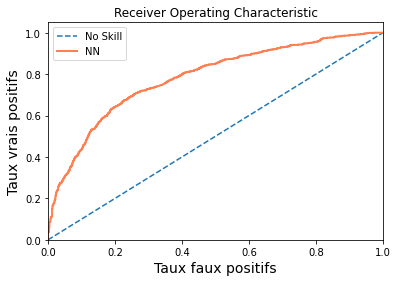

In [ ]:
model_auc(w2v_trained, x_test.text.to_numpy(), y_test_ohe)

In [ ]:
del cpu, nb_token_max, nb_token_std, w2v_trained, wv

## réseau de neurones avec couche d'embeding sans (plongement / word2vec) en initiant avec des poids aléatoire

### pre-trained word2vec

fitrer dés les fichiers csv pour alléger en mémoire

In [ ]:
# gc.collect()
# import gensim.downloader as api
# model = api.load("word2vec-google-news-300")
# model.save_word2vec_format(root+'/Downloads/word2vec-google-news-300.w2v.bin', binary=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# https://github.com/RaRe-Technologies/gensim-data 
# "word2vec-google-news-300" save with
# préférer tweeter au lieu de google news
gc.collect()
wv = KeyedVectors.load_word2vec_format(root+'/Downloads/word2vec-google-news-300.w2v.bin', binary=True, unicode_errors='ignore')
w2v_pre_trained = make_model(max_input_length, make_vocabulary(wv), make_embedding_matrix(wv))
print(w2v_trained.summary())

In [ ]:
fit_model(w2v_trained, x_train.text.to_numpy(), y_train_ohe, x_val.text.to_numpy(), y_val_ohe, cache=root+'/Cache/model_w2v_trained.h5')
w2v_trained.load_weights(root+'/Cache/model_w2v_trained.h5')

In [ ]:
model_accuracy(w2v_trained, x_train.text.to_numpy(), y_train_ohe, x_test.text.to_numpy(), y_test_ohe)

In [ ]:
model_auc(w2v_trained, x_test.text.to_numpy(), y_test_ohe)

#### trained binary

### Glove

#### pretrained

#### trained

## LSTM

## Bert

hugging face, transformer, refit sur les données du datasets

## deploiement

flask | fast API -> cloud limite (ram, carte graphique) des service gratuits ou regression logistique (heroku) pour contrainte technique ou azure|aws(serveless))

critére (rapidité de mise en oeuvre, entretien, temps d'écution)

## blog